Постановка задачи: разработать рекомендательную систему для аптек. Представьте, что вы приходите на кассу, а у кассира во время формирования чека всплывает подсказка, что можно вам ещё порекомендовать.

Критерий проверки	Баллы
Построен валидационный датасет. Валидация сделана с учётом времени либо обосновано, почему валидация в данном случае бессмысленна	2
Построены контентные рекомендации (по названиям товаров в корзине)	4
Построены рекомендации с Word2Vec по чековым данным (обучены эмбеддинги товаров по чековым последовательностям)	4
Построена двухстадийная рекомендательная система (опционально, с любым ранжированием)	2
Подсказки

Всегда нужен валидационный сет, как его построить?
Подойдут ли здесь user-item рекомендации? Есть ли у нас идентификатор пользователя?
Можем ли построить рекомендации по названию товаров?
А что если посмотреть на чек как на документ, а на идентифиваторы items — как на слова, и обучить Word2Vec?

### Итоговый проект модуля по рекомендательным системам

In [11]:
import string
import annoy
import numpy as np
import pandas as pd
import pickle

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from gensim.models import FastText
from tqdm.notebook import tqdm
import time
from datetime import datetime
input_path = './'
tqdm.pandas()

Ввиду того, что приходиться работать с файлами больших размеров рекомендуется 
### НЕ запускать абзацы 
вплоть до раздела "Загрузка подготовленных данных".  
Файлы необходимые для запуска разделов "Word2vec" и "Item2vec" прилагаются:

"train.feather",
"test.feather",
"checks_train.pkl",
"checks_test.pkl",
"Product_dict.pkl"

https://drive.google.com/file/d/1Ivq9Q0ETkcqXOWXjx8ZRUYtBJyP3om8m/view?usp=sharing

Загрузим датасет

In [2]:
#dtypes = {'contact_id':'int32','shop_id':'int32','product_id':'int32','name':str,'product_sub_category_id':'int32','product_category_id':'int32','brand_id':'int32','quantity':str}
#df = pd.read_csv(input_path+'data.csv', dtype=dtypes, parse_dates=['sale_date_date'], nrows = 20000000, encoding = 'utf-8')


def read_csv_pgbar(csv_path, chunk_rows, nrows=-1, **kwargs):
    t0 = time.perf_counter()
    tmp = pd.read_csv(csv_path, nrows=1)
    header = tmp.columns

    if 'parse_dates' in kwargs:
        kwargs['parse_dates'] = [header.to_list().index(x)
                                 for x in kwargs['parse_dates']]

    if nrows < 0:
        nrows = sum(1 for _ in open(csv_path, 'r')) - 1  # minus the header
    chunk_list = []

    with tqdm(total=nrows, desc='Rows read: ') as bar:
        skip_rows = 1
        rows_left = nrows
        count = 0
        while rows_left > chunk_rows:
            if count == 0:
                tmp = pd.read_csv(csv_path, skiprows=skip_rows,
                                  header=None, nrows=chunk_rows,  **kwargs)
            else:
                tmp = pd.concat([tmp, pd.read_csv(
                    csv_path, skiprows=skip_rows, header=None, nrows=chunk_rows,  **kwargs)], axis=0)

            skip_rows = skip_rows + chunk_rows
            rows_left = nrows - (skip_rows)+1
            bar.update(chunk_rows)
            count += 1

        if rows_left <= chunk_rows:
            chunk_rows = rows_left
            if count == 0:
                tmp = pd.read_csv(csv_path, skiprows=skip_rows,
                                  header=None, nrows=chunk_rows,  **kwargs)
            else:
                tmp = pd.concat([tmp, pd.read_csv(
                    csv_path, skiprows=skip_rows, header=None, nrows=chunk_rows,  **kwargs)], axis=0)

            bar.update(chunk_rows)

    df = tmp.reset_index(drop=True)
    df.columns = header
    print('Finish reading csv file, elapsed:', time.perf_counter()-t0)
    return df

In [3]:
# Оптимизируем загрузку с помощью у
dtypes = {'contact_id': 'int32', 'shop_id': 'int32', 'product_id': 'int32', 'name': str,
          'product_sub_category_id': 'int32', 'product_category_id': 'int32', 'brand_id': 'int32', 'quantity': str}
df = read_csv_pgbar(input_path+'data.csv', chunk_rows=5000000, nrows=20000000,
                    dtype=dtypes, parse_dates=['sale_date_date'],  encoding='utf-8')

Rows read:   0%|          | 0/20000000 [00:00<?, ?it/s]

Finish reading csv file, elapsed: 116.819778538


### EDA. Изучим датасет..

In [4]:
df[100:105]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
100,2018-12-07,2745991,1566,19626,(78352) Прополиса настойка жидк.фл.25мл №1,706,163,-1,"2,00"
101,2018-12-07,2743825,1388,161562,"(185466) PL Бальзам для губ Фруктовый микс 4,2г",481,113,1520,"3,00"
102,2018-12-07,1062476,1559,162991,(185833) ЯБудуЖить100Лет Гематоген спортивный 40г,433,101,4474,"6,00"
103,2018-12-07,1038470,123,158600,(181232) PL Шприц одноразовый 3-комп. 5мл №1,762,176,1520,"10,00"
104,2018-12-07,2449508,653,155688,(153908) Ит Ми Фрутилад батончик Черника 30г,571,128,4128,"6,00"


In [5]:
df.columns.to_list()

['sale_date_date',
 'contact_id',
 'shop_id',
 'product_id',
 'name',
 'product_sub_category_id',
 'product_category_id',
 'brand_id',
 'quantity']

Можно сделать следующие предположения:
Cтрока описывает приобретение отдельного продукта (item или product).

item's property: product_id, name, product_sub_category, product_category, brand, and (а number in the name property - 'num_from_name' )

Можно предположить, что shop_id - id магазина, где приобретался продукт на дату sale_date_date..
При этом отсутствует временная метка - то есть порядок приобретения внутри дня отсутствует и таким образом мы получаем корзину товаров приобретенную в некую дату в некоем магазине и с неким contact_id.
Contact_id - что это - большой вопрос.. 

Если предположить, что это зарегистрированный покупатель, то тогда окажется, что наши покупатели ходят в аптеку по несколько раз в неделю, например:

In [5]:
df[(df['contact_id'] == 730404)].drop_duplicates('sale_date_date').head(10)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4732950,2018-01-08,730404,862,80944,(67303) Панкреатин таб.п.о.кишечнораств. 30 ЕД...,601,135,-1,"1,00"
4735089,2018-01-05,730404,862,156136,(180238) PL Бахилы медицинские №10 (5 пар),414,97,1520,"1,00"
4803228,2018-01-04,730404,862,144041,(115096) Стрептоцид пор 2г пак N1,706,163,-1,"2,00"
4814992,2018-01-01,730404,862,78056,(64340) 9 месяцев Фолиевая кислота таб.п.п.о.0...,424,101,1702,"1,00"
4818404,2018-01-06,730404,862,71564,(46459) Черника-форте 250 мг №150,574,129,1348,"1,00"
4888488,2018-01-28,730404,862,83462,(15853) Аскорбиновая кислота с глюкозой тб 100...,429,101,-1,"4,00"
4889156,2018-01-27,730404,862,35385,(106244) Неосмектин пор. д/сусп. пак. 3 гр. №30,595,135,-1,"0,10"
4889826,2018-01-31,730404,862,70604,(55217) Марвелон тб №21х3,450,105,-1,"0,333"
5175314,2018-02-13,730404,862,32087,(112032) Ямми Турбогематоген детский 30г,433,101,2481,"1,00"
5196084,2018-02-14,730404,862,129361,(101258) Кэа Дерма Маска д/лица и шеи кислород...,505,116,1837,"2,00"


#### Тогда есть предположение, что contact_id это номер кассы в магазине...
#### А чек - это данные сгруппированные по составному индексу [sale_date, shop_id, contact_id] 
#### Но тогда тоже встречаются довольно странные розничные "покупатели", которые закупают как оптовики:

In [6]:
df[(df.sale_date_date == '2018-04-12') & (df.contact_id == 1073942)
    & (df.shop_id == 848)]['product_id'].count()

388

In [7]:
df_ = df[(df.sale_date_date == '2018-04-12') & (df.contact_id ==
                                                1073942) & (df.shop_id == 848)][['product_id', 'name']]

In [8]:
sum(df_.duplicated())

46

In [9]:
df_[df_.duplicated(keep=False)].sort_values(['product_id'])

,product_id,name
12356447,28548,(92002) Найзилат таб.п.п.о.600мг №20
12804497,28548,(92002) Найзилат таб.п.п.о.600мг №20
12205813,31212,(118125) Кардиомагнил таб.п.п.о.75мг №100
12205837,31212,(118125) Кардиомагнил таб.п.п.о.75мг №100
12177598,31212,(118125) Кардиомагнил таб.п.п.о.75мг №100
...,...,...
12350908,154015,(122354) Ацикловир мазь д/местн.и наружн.прим....
12196779,154256,(122353) PL Проктонис Крем ректальный туба 30мл
12728625,154256,(122353) PL Проктонис Крем ректальный туба 30мл
12201149,161241,(185026) PL Масло Репейное с касторовым маслом...


### 388 товаров, среди которых аж 46 дубликатов! Ну что это за чек? Ясно, что это объединение чеков за один день по одной кассе в этом магазине. Как тогда по таким "дневным чекам" можно хоть что-то адекватно рекомендовать...



### Что такое тогда чек?



Почистим датасет..

In [10]:
df = df.dropna()

In [11]:
df[(df['product_id'] == 129195) | (df['product_id'] == 129484)].head(2)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4776837,2018-01-05,1393270,1505,129195,(48791) Свободная сумма НДС18% (служебный),-1,-1,-1,"1,00"
4776838,2018-01-05,1789248,1522,129195,(48791) Свободная сумма НДС18% (служебный),-1,-1,-1,"1,00"


In [12]:
# удалим служебную информацию
df = df.drop(index=df[(df['product_id'] == 129195)
                      | (df['product_id'] == 129484)].index)
# удалим числовой артикул в скобках из текста названия
tqdm.pandas()
df['name'] = df.name.progress_apply(
    lambda x: ' '.join(x.strip().split()[1:]) if x == x else x)

  0%|          | 0/19819985 [00:00<?, ?it/s]

In [13]:
df[df['name'] == 'название'].head(2)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
42646,2018-12-07,1376371,1503,349434,название,-1,-1,-1,"1,00"
129618,2018-12-08,2740131,1503,349434,название,-1,-1,-1,"1,00"


In [ ]:
# почистим датасет от неопределенных "названий"
df = df.drop(df[df['name'] == 'название'].index)

In [ ]:
df[(df['product_id'] == 129195) | (df['product_id'] == 129484)]

In [ ]:
df[df['name'] == 'название'].head(2)

#### Обратим внимание на последовательность дат.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['sale_date_date'])

Выглядит как будто объединены два датасета с разрывом в 4 месяца и с противоположным порядком следования дат. При этом непонятно, в каком порядке следуют данные внутри дня. 

1. Наличие двух разделенных 4-месячным интервалом датасетов дает основание провести разбиение выборки на train и test именно по этой точке разделения.
2. С другой стороны очевидно, что способ накопления данных в датасетах разный, так что имеет смысл отбросить меньший по размеру (более поздний по датам) датасет и провести разбиение только внутри более раннего датасета большего размера. Да, мы конечно уменьшим располагаемые данные для обучения и тестирования, но зато будем уверены в соответствии способов получения выборок train и test. Разобъем в дальнейшем с соотношением примерно 90%/10%

In [ ]:
df['sale_date_date'].diff().dt.days.min()

In [ ]:
df[df['sale_date_date'].diff().dt.days == -302].index[0]

In [ ]:
# Отбрасываем более позднюю выборку
df = df[df[df['sale_date_date'].diff().dt.days == -302].index[0]:]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['sale_date_date'])

In [ ]:
df['sale_date_date'].diff().dt.days.value_counts()

In [ ]:
dv = df['sale_date_date'].diff().dt.days.value_counts()
sum(dv[dv.keys() < 0].values)

Оказывается в 21526 строчках сбивается порядок дат.. Ну ок. Видимо данные агрегрировались с запозданием из разных аптек сети. Будем надеятся, что данные с каждой отдельной локации не переплетались с другими, а вставлялись в базу неразрывными кусками. 

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# сохраним для дальнейшей работы
df.to_feather(input_path + 'data_reduced.feather')

In [46]:
# загрузим почищенный датасет
df = pd.read_feather(input_path + 'data_reduced.feather')

Рассмотрим, например,следующий кусок данных:

In [ ]:
df[8243:8248]

Строки с индексами 8245 и 8246 идут друг за другом и имеют одинаковые sale_date_date, contact_id, shop_id..

#### Тогда можно предположить , что чеком может считаться последовательность идущих один за одним строк с единым составным индексом [sale_date_date, contact_id, shop_id]

 При этом нет никакой гарантии, что два чека от одной локации не могут слипнуться в один так как нет временной отметки.  Ну какого художника нельзя было нормальные данные для закрепления материала именно по Рекомендательным системам дать? 99 % процентов времени убухано на поиск ответа на вопрос: что такое чек в данном задании.

#### Найдем все такие последовательности.

In [ ]:
# Создадим вспомогательные колонки
df['diff_date'] = df['sale_date_date'].diff()
df['diff_shop_id'] = df['shop_id'].diff()
df['diff_contact_id'] = df['contact_id'].diff()

zero_delta = df.loc[0, 'sale_date_date']-df.loc[0, 'sale_date_date']
df.loc[0, 'diff_date'] = zero_delta
df.loc[0, 'diff_shop_id'] = 0
df.loc[0, 'diff_contact_id'] = 0

In [ ]:
df['diff_date'] = df['diff_date'].dt.days
df['check_id'] = np.zeros(len(df))
df.loc[(df.diff_date != 0) | (df.diff_shop_id != 0)
       | (df.diff_contact_id != 0), 'check_id'] = 1

counter = 0


def make_check_id(x):
    global counter

    if (x == 1):
        counter += 1
    return counter


# Получим новый идентификатор вышеуказанных последовательностей - иденификатор чеков
df['check_id'] = df['check_id'].progress_apply(lambda x: make_check_id(x))

In [ ]:
# Удалим ненужные колонки.
df = df.drop(labels=['diff_date', 'diff_shop_id', 'diff_contact_id'], axis=1).reindex(columns=['check_id', 'sale_date_date',
                                                                                               'contact_id', 'shop_id', 'product_id', 'name', 'product_sub_category_id', 'product_category_id', 'brand_id', 'quantity'])

In [ ]:
df = df.reset_index(drop=True)
df.to_feather(input_path + 'checks.feather')  # сохраним для дальнейшей работы

In [48]:
# загрузим почищенный датасет
df = pd.read_feather(input_path + 'checks.feather')

Еще раз посмотрим на данные:

In [ ]:
df[8243:8248]

#### Видно, что строки с индексами 8245 и 8246  идущие друг за другом, имеющие одинаковые sale_date_date, contact_id, shop_id имеют ОДИНАКОВЫЙ check_id = 8244, то есть объединены в один чек.

In [ ]:
df['check_id'].tail(1)  # Всего у нас чеков 14924636

In [ ]:
# Распределение количества товаров в одном чеке
df.groupby('check_id')['product_id'].count().value_counts()

Видно, что подавляющее число чеков состоит из одной покупки.

In [ ]:
# Отберем чеки с числом покупок больше единицы
dups = df[df.duplicated('check_id', keep=False)]
dups

Можно обратить внимание на очередную "странность": chek_id=14923882 	имеет две покупки и причем одинаковые... то есть как бы кассир пробил два раза одно и тоже.. Посмотрим часто ли такое бывает.

In [ ]:
dups[dups.duplicated(['check_id', 'product_id'], keep=False)].groupby(
    'check_id')['product_id'].count().sort_values()

3181 чеков имеют дупликаты товаров..Причем один чек содержит их аж 121 !!!

In [ ]:
df[df.check_id == 6394399]

### У меня нет объяснения происхождения этих феноменальных чеков. Либо я не прав и чек это еще что-то другое!!!
Вообще - это вопрос постановки задачи. Я потратил на подготовку этого задания почти месяц и только из-за суперминималистичных условий этого задания.
Объяснять все-таки надо, что понимается под чеком!!! 

### Разбиение датасета на обучающую и валидационную выборки

In [ ]:
# Почистим датасет
# отделим артикул в скобках от текста названия
df['name'] = df.name.progress_apply(
    lambda x: ' '.join(x.strip().split()[1:]) if x == x else x)

In [ ]:
# Сортируем даты по возрастанию
df = df.sort_values('sale_date_date').reset_index(drop=True)
# сохраним для дальнейшей работы
df.to_feather(input_path + 'data_ready_to_split.feather')

In [2]:
df = pd.read_feather(input_path + 'data_ready_to_split.feather')

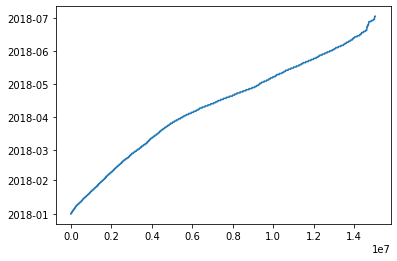

In [4]:
import matplotlib.pyplot as plt
plt.plot(df['sale_date_date'])

In [5]:
def train_test_split(df, test_proportion):
    # разбивает датасет учитывая test_proportion и разграничивая даты тесто и трейна
    len_df = len(df)
    train_d = round((1-test_proportion)*len_df)
    while (df.loc[train_d, 'sale_date_date'] == df.loc[train_d-1, 'sale_date_date']) and (train_d < len_df):
        train_d += 1
    print('true test_proportion', 1-(train_d/len_df))
    return df[:train_d], df[train_d:]

In [6]:
# для дальнейшей работы с эмбеддингами требуется перевести целочисленные объекты в строки
df['product_id'] = df['product_id'].astype(str)

In [7]:
train, test = train_test_split(df, 0.1)

true test_proportion 0.0998515398395795


In [8]:
train.tail()

,check_id,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
13541012,12407971,2018-06-07,361717,272,61563,"мазь д/наружн.прим.0,05% туба 30г №1",467,110,-1,"1,00"
13541013,12407973,2018-06-07,1069728,348,68879,таб.10мг №50,738,170,-1,"1,00"
13541014,12407969,2018-06-07,141832,345,135427,капли глазн 4% фл 10 мл. пласт. флак.-кап.,575,129,-1,"1,00"
13541015,12407974,2018-06-07,116582,308,84421,мазь простая 25г N1,467,110,-1,"1,00"
13541016,12407970,2018-06-07,874236,266,156491,капс.кишечнораст.20мг №30,595,135,-1,"1,00"


In [9]:
test.head()

,check_id,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
13541017,12445782,2018-06-08,499581,266,25575,Гексал таб.10мг №50,738,170,-1,"1,00"
13541018,12445795,2018-06-08,1128997,346,50906,сироп 15 мг/5 мл. фл. 100 мл. с мерн. стак.,700,162,-1,"1,00"
13541019,12445794,2018-06-08,1074123,608,161495,"спрей наз. 0,1% фл.15мл",701,162,-1,"1,00"
13541020,12445793,2018-06-08,55296,151,151429,"Кло таб.п.п.о. 40мг+12,5мг №28",738,170,-1,"1,00"
13541021,12445792,2018-06-08,522930,326,64731,"А таб.п.п.о.2,5мг+0,625мг №30",738,170,-1,"1,00"


In [10]:
del df

In [11]:
# сохраним для дальнейшей работы
train.to_feather(input_path + 'train.feather')
test = test.reset_index(drop=True)
test.to_feather(input_path + 'test.feather')

## Загрузка подготовленных данных

In [2]:
# загрузим подготовленную обучающую выборку
train = pd.read_feather(input_path + 'train.feather')

In [3]:
# загрузим подготовленную валидационную выборку
test = pd.read_feather(input_path + 'test.feather')

## Можем ли построить рекомендации по названию товаров?
    Названия товаров не содержат достаточно семантической информации, кроме некоторых товаров типа "шприц одноразовый" или "пакет-майка". В большей степени названия товаров будут являться индентификаторами, такими же как 'product_id'. Так как у нас нет корпуса текста из которого было бы ясно, что, например, Левофлоксацин  это аналог Таваника, а Аспирин - тоже самое что Ацетилсалициловая кислота.  К тому же контекст в названии товара практически отсутствует, так что модель скорее всего не сможет найти адекватные эмбеддинги. Если бы товары содержали подробные описания и  предназначения то осмысленность таких рекомендаций повысилась. Однако все же построим  контентные рекомендации по названиям товаров в корзине, чтобы убедиться в вышесказанном. 

### Word2Vec

Обучение модели на корпусе названий продуктов из обучающей выборки - очень ресурсоемко и затратно. Модель word2vec учитывает частотность слов, но у нас одинаковые названия продуктов и поэтому не имеет смысла их дублировать по сотне раз. Разумнее обучить модель на корпусе названий из словаря 'Product_dict'.

#### Обучаем на корпусе предложений из словаря Product_dict

In [12]:
with open(input_path+'Product_dict.pkl', 'rb') as f:
    product_dict = pickle.load(f)
p_d = pd.DataFrame.from_dict(product_dict, orient='index').reset_index()
p_d.columns = ['product_id', 'name']
# отделим артикул в скобках от текста названия
p_d['name'] = p_d['name'].apply(lambda x: ' '.join(x.strip().split()[1:]))
# почистим датасет от неопределенных "названий"
p_d = p_d.drop(p_d[p_d['name'] == 'название -1'].index)
p_d = p_d.drop(p_d[p_d['name'] == '-1'].index)
p_d = p_d.drop_duplicates('name').reset_index(drop=True)

In [13]:
# Для фильтрации пунктуации
exclude = set(string.punctuation)
# Для приведения слов в начальной форме
morpher = MorphAnalyzer()


# Для фильтрации стоп-слов
sw = set(get_stop_words("ru"))


def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [14]:
# Загрузим названия товаров и преобразуем к нормализованному виду
items = p_d.copy()
items['name'] = items['name'].progress_apply(lambda x: preprocess_txt(str(x)))

  0%|          | 0/27493 [00:00<?, ?it/s]

In [15]:
sentences = [i for i in items['name'] if len(i) > 2]

In [16]:
# Обучим модель fasttext на названиях товаров
modelFT = FastText(sentences=sentences, vector_size=20, min_count=1, window=50)

In [17]:
# Для того, чтобы быстро находить айтемы положим эмбединги их тайтлов в ANN индекс
# Создадим объект индекса
ft_index_items = annoy.AnnoyIndex(20, 'angular')

index_map_items = {}
counter = 0

for i in tqdm(range(len(items))):
    n_ft = 0
    index_map_items[counter] = (
        items.loc[i, "name"], items.loc[i, "product_id"])
    vector_ft = np.zeros(20)
    # Каждое слово обернем в эмбеддинг
    for word in items.loc[i, "name"]:
        if word in modelFT.wv.key_to_index:
            vector_ft += modelFT.wv[word]
            n_ft += 1
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
    ft_index_items.add_item(counter, vector_ft)
    counter += 1

ft_index_items.build(10)

  0%|          | 0/27493 [00:00<?, ?it/s]

True

Мне не удалось придумать (а также найти в литературе) как можно оценить качество этой модели, кроме как на глаз.

In [18]:
# Попробуем порекомендовать.Оценка качества "На глаз"


def recommend_by_id(item_id):
    # Получим тайтл айтема по идентификатору
    name = p_d.loc[p_d['product_id'] == item_id, 'name'].values[0]
    print(name)
    name = preprocess_txt(name)

    vector_ft = np.zeros(20)
    n_ft = 0
    # Каждое слово обернем в эмбеддинг
    for word in name:
        if word in modelFT.wv.key_to_index:
            vector_ft += modelFT.wv[word]
            n_ft += 1
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
    # Найдем ближайшие по тайтлу
    rec_items = ft_index_items.get_nns_by_vector(
        vector_ft, 5, include_distances=False)
    return [index_map_items[i][0] for i in rec_items]

In [19]:
p_d[p_d.product_id == '168308']

,product_id,name
0,168308,Пакет-майка 25см х 45см 906


In [20]:
recommend_by_id('168308')

Пакет-майка 25см х 45см 906


[['пакетмайк', '25см', 'х', '45см', '906'],
 ['пакетмайк', '40см', 'х', '70см', '906'],
 ['пакет', '30см', 'х', '60см', '906'],
 ['пакет', '20см', 'х', '30см', '906'],
 ['пакет', '28см', 'х', '50см', '906']]

In [21]:
# Попробуем порекомендовать.Оценка качества "На глаз"


def recommend_by_name(name):
    # Получим тайтл айтема по идентификатору

    print(name)
    name = preprocess_txt(name)

    vector_ft = np.zeros(20)
    n_ft = 0
    # Каждое слово обернем в эмбеддинг
    for word in name:
        if word in modelFT.wv.key_to_index:
            vector_ft += modelFT.wv[word]
            n_ft += 1
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
    # Найдем ближайшие по тайтлу
    rec_items = ft_index_items.get_nns_by_vector(
        vector_ft, 5, include_distances=False)
    return [index_map_items[i][0] for i in rec_items]

In [22]:
recommend_by_name('шприц одноразовый')

шприц одноразовый


[['шприц', 'одноразовый', 'sf', 'medical', '3комп2мл', '№1стм', '762'],
 ['шприц', 'одноразовый', 'игла', '3комп10мл', 'уп', 'n100', '762'],
 ['шприц', 'одноразовый', 'sf', 'medical', '3комп3мл', '№1стм', '762'],
 ['шприц', 'одноразовый', '3комп2мл', 'игла', '23g', '№1', '1'],
 ['шприц', 'инсулин', 'игла', '3комп', 'n1', '1']]

In [23]:
recommend_by_name('пакет-майка')

пакет-майка


[['пакет', 'упакпрозрс', 'голографичрисунок', '906'],
 ['пакет', '30х40', '906'],
 ['подгузник',
  'памперс',
  'премиум',
  'кэа',
  'ньюборн',
  '25кг',
  'уп',
  '№20',
  '807'],
 ['тампон', 'котекс', 'супер', 'уп', '№16', '8', 'промоуп', '558'],
 ['тампон', 'котекс', 'супер', 'уп', '№16', '558']]

In [24]:
p_d[p_d.name.str.lower().str.contains('аспирин')]

,product_id,name
2788,25485,Аспирин-C Байер таб.шип.№10 397
4616,140636,Аспирин Экспресс таб.д/приг.шипучего напитка 5...
4717,93668,Аспирин Кардио табл. п.о. раствор./кишечн. 100...
7899,112932,Аспирин Комплекс пор.шипуч.д/приг.р-ра №10 703
10486,67454,Аспирин Кардио табл. п.о. раствор./кишечн. 300...
18957,145313,Аспирин Кардио табл. п.о. раствор./кишечн. 100...
20534,44433,Аспирин Кардио табл. п.о. раствор./кишечн. 100...


In [25]:
recommend_by_id('145313')

Аспирин Кардио табл. п.о. раствор./кишечн. 100 мг. №28 738


[['аспирин', 'кардио', 'табла', 'растворкишечн', '100', 'мг', '№28', '738'],
 ['лирика', 'капс', '25', 'мг', '№14', '641'],
 ['варфарин', 'никомёд', 'табла', '25', 'мг', '№100', '738'],
 ['аромазин', 'табла', '25', 'мг', '№30', '642'],
 ['варфарин', 'никомёд', 'табла', '25', 'мг', '№50', '738']]

In [26]:
recommend_by_name('Аспирин Кардио табл. п.о. раствор./кишечн. 300 мг. №20 648')

Аспирин Кардио табл. п.о. раствор./кишечн. 300 мг. №20 648


[['аспирин', 'кардио', 'табла', 'растворкишечн', '300', 'мг', '№20', '648'],
 ['леркамена', '20', 'табла', '20', 'мг', '№28', '738'],
 ['кальцийсандоза', 'форт', 'табла', 'шип', '1000', 'мг', '№20', '644'],
 ['кардосало', '20', 'табла', 'ппо', '20', 'мг', '№28', '738'],
 ['нолицин', 'табла', '400', 'мг', '№20', '403']]

#### Очевидно, что модель плохо находит даже похожие названия.

### Item2Vec

Примем каждый товар (вернее его ID) в качестве слова, а последовательность приобретенных товаров предположительно одним покупателем или "чек" в качестве предложения или текста. Тогда применяя word2vec подход можно получить эмбеддинги товаров и использовать полученные веса модели для выявления 'complementary' товаров для товаров находящихся в одном чеке.

In [6]:
train.head()

,check_id,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,99776,2018-01-01,232155,145,124157,Презервативы Ультратонкие №12,691,161,2486,"1,00"
1,176107,2018-01-01,718367,101,114973,Средство гигиенич. д/промывания носоглотки д/д...,698,162,-1,"1,00"
2,176106,2018-01-01,847586,247,112234,для детей сусп.д/приема внутрь 100мг/5мл фл.20...,703,162,-1,"1,00"
3,176106,2018-01-01,847586,247,62007,тб жеват б/сахара мятн 80мг N24,595,135,-1,"1,00"
4,176105,2018-01-01,42544,101,61290,сироп д/младенцев фл с дозатором 15мл №1,597,135,-1,"1,00"


In [7]:
train.count()

check_id                   13541017
sale_date_date             13541017
contact_id                 13541017
shop_id                    13541017
product_id                 13541017
name                       13541017
product_sub_category_id    13541017
product_category_id        13541017
brand_id                   13541017
quantity                   13541017
dtype: int64

In [8]:
train = train.drop_duplicates()

In [9]:
train.count()

check_id                   13538475
sale_date_date             13538475
contact_id                 13538475
shop_id                    13538475
product_id                 13538475
name                       13538475
product_sub_category_id    13538475
product_category_id        13538475
brand_id                   13538475
quantity                   13538475
dtype: int64

In [76]:
checks_train = train.groupby(['check_id'])['product_id'].progress_apply(list)

  0%|          | 0/13465470 [00:00<?, ?it/s]

In [77]:
checks_train

check_id
0            [90546]
1            [72074]
2           [111277]
3            [83335]
4            [73855]
              ...   
14305132    [117333]
14305133     [41844]
14305134     [68751]
14305135     [85121]
14305136    [138857]
Name: product_id, Length: 13465470, dtype: object

In [16]:
# Отбросим чеки с единичными покупками
checks_train = checks_train[checks_train.str.len() > 1]

In [19]:
checks_train

check_id
8244          [78049, 64731]
11100        [124263, 67974]
13526         [53850, 65540]
13884         [79147, 52938]
16706        [53488, 114869]
                  ...       
14300856    [127232, 142404]
14302357     [127243, 21252]
14303932     [76420, 126741]
14303965      [43401, 79724]
14304386      [65702, 41353]
Name: product_id, Length: 59614, dtype: object

In [80]:
# checks_train = pd.Series(checks_train.values)
with open(input_path+'checks_train.pkl', 'wb') as f:
    pickle.dump(checks_train, f)

In [12]:
with open(input_path+'checks_train.pkl', 'rb') as f:
    checks_train = pickle.load(f)

In [13]:
# GET SENTENCES
sentences = checks_train
longest = np.max(sentences.apply(len))
sentences = sentences.values
print(longest)

112


In [14]:
len(sentences)

59614

#### THE MODEL

In [15]:
import gensim

# set the model
window_size = longest
epochs = 5
embedding_size = 100
min_count = 3  # Drop infrequent items in dataset
number_of_negative_samples = 7
ns_exponent = 0

model = gensim.models.Word2Vec(sentences, sg=1, vector_size=embedding_size, window=window_size, min_count=min_count,
                               workers=4, hs=0, negative=number_of_negative_samples, ns_exponent=ns_exponent, epochs=epochs)
model.save(input_path+'model18')

vocab_size = len(model.wv.key_to_index)
print(vocab_size)

7508


In [16]:
from annoy import AnnoyIndex

# Для того, чтобы быстро находить айтемы положим эмбединги их тайтлов в ANN индекс
# Создадим объект индекса

embedding_size = 100
ft_index_items = AnnoyIndex(embedding_size, 'angular')

index_map_items = {}
counter = 0


for vec in tqdm(model.wv.key_to_index.items()):
    n_ft = 0

    vector_ft = np.zeros(embedding_size)
    product = vec[0]
    wv_idx = vec[1]
    index_map_items[counter] = product

    # Получим "complementary" эмбеддинг
    # (для  "similar" нужно писать model.wv[wv_idx])
    vector_ft = model.syn1neg[wv_idx]

    ft_index_items.add_item(counter, vector_ft)
    counter += 1
ft_index_items.build(10)

  0%|          | 0/7508 [00:00<?, ?it/s]

True

### Evaluation

In [19]:
test.head()

,check_id,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,12445782,2018-06-08,499581,266,25575,Гексал таб.10мг №50,738,170,-1,"1,00"
1,12445795,2018-06-08,1128997,346,50906,сироп 15 мг/5 мл. фл. 100 мл. с мерн. стак.,700,162,-1,"1,00"
2,12445794,2018-06-08,1074123,608,161495,"спрей наз. 0,1% фл.15мл",701,162,-1,"1,00"
3,12445793,2018-06-08,55296,151,151429,"Кло таб.п.п.о. 40мг+12,5мг №28",738,170,-1,"1,00"
4,12445792,2018-06-08,522930,326,64731,"А таб.п.п.о.2,5мг+0,625мг №30",738,170,-1,"1,00"


In [20]:
test = test.drop_duplicates()

In [29]:
checks_test = test.groupby(['check_id'])['product_id'].progress_apply(list)

  0%|          | 0/1459167 [00:00<?, ?it/s]

In [31]:
# Отбросим чеки с единичными покупками
checks_test = checks_test[checks_test.str.len() > 1]

In [32]:
# checks_train = pd.Series(checks_train.values)
with open(input_path+'checks_test.pkl', 'wb') as f:
    pickle.dump(checks_test, f)

In [17]:
with open(input_path+'checks_test.pkl', 'rb') as f:
    checks_test = pickle.load(f)

In [5]:
checks_test

check_id
11971028           [116819, 142470]
11972589            [122512, 46797]
11972616            [118026, 42878]
11973244           [124000, 134832]
11975976           [134632, 141161]
                     ...           
14923031            [32659, 124630]
14923036    [33239, 133629, 156355]
14923038            [83424, 163273]
14923040             [35480, 53488]
14923043             [81888, 57357]
Name: product_id, Length: 30963, dtype: object

### Оценка эффективности рекомендации товара по имеющимся в чеке

In [18]:
import time

order_count = 0
evaluated_order_count = 0
hitCount = 0
evaluate_min_item_orders = 2


start_time = time.time()

# Loop Checks

for items in tqdm(checks_test.items()):
    t0 = time.perf_counter()
    order_count += 1

    #OrderID and Products
    # order_ID = items[0]  # not used
    product_IDs = items[1]

    # Минимальный размер чека (не меньше двух, иначе не проверим)
    if len(product_IDs) < evaluate_min_item_orders:
        continue

    # Убираем каждый товар из чека и смотрим удалось ли его предсказать по товарам оставшимся в чеке

    for i in range(len(product_IDs)):
        product_IDs = items[1].copy()
        removed_ProductID = product_IDs.pop(i)
        averaged_vector_for_products = np.zeros(embedding_size)
        n_ft = 0
        # Каждое "слово"(товар) из оставшихся в чеке  обернем в эмбеддинг
        for product_ID in product_IDs:
            if product_ID in model.wv.key_to_index:
                averaged_vector_for_products += model.wv[product_ID]
                n_ft += 1
        if n_ft > 0:
            averaged_vector_for_products = averaged_vector_for_products / n_ft
            
        # Составим список рекомендаций из 10 ближайших 'complementary' товаров
        rec_items = ft_index_items.get_nns_by_vector(
            averaged_vector_for_products, 10, include_distances=True)[0] 
        recommendations = [index_map_items[recm] for recm in rec_items]

        evaluated_order_count += 1
        
        # если получилось найти "удаленный" товар в списке рекомендаций, то засчитываем рекомендацию
        if (removed_ProductID in recommendations): 
            hitCount += 1 # счетчик удачных рекомендаций
print("Всего чеков",order_count)
print("Всего полученных рекомендаций товаров", evaluated_order_count)
print("Эффективность полученных рекомендаций :", hitCount/evaluated_order_count*100)

0it [00:00, ?it/s]

Всего чеков 30963
Всего полученных рекомендаций товаров 73115
Эффективность полученных рекомендаций : 3.1594064145524174


### Заключение.
Данный проект оказался для меня наиболее долгим из-за на редкость минималистичной постановки задачи. 
Плюс в том, что пришлось изучить более 20 статей по темам word2vec, prod2vec, item2vec.
Удалось реализовать не только word2vec модель (на основе материалов курса), но и более сложную item2vec c эффективностью рекомендаций около 3%.